In [ ]:
import json
import os
import pandas as pd
import re
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Описание набора данных

## Для решения задачи автоматической генерации кратких содержаний (суммаризации) русскоязычных текстов были использованы два публично доступных набора данных: Gazeta и русскоязычная часть датасета XLSum. 

## *1. Датасет Gazeta (≈75 тысяч новостей)*

Источник: Датасет Gazeta представляет собой коллекцию статей, опубликованных на новостном портале Gazeta.ru. Он охватывает широкий спектр тем, включая политику, экономику, общество, культуру, спорт и происшествия.

Структура: Каждая запись содержит URL-адрес (url), заголовок (title), полный текст статьи (text), резюме (summary), и дату публикации (date).


https://github.com/IlyaGusev/gazeta

## *2. Датасет XLSum  (≈77 тысяч новостей)*

Источник: XLSum – это крупномасштабный многоязычный датасет для задачи суммаризации, содержащий более миллиона пар статья-резюме на различных языках. Статьи для XLSum были собраны из новостных публикаций BBC.

Структура: Для данного проекта была использована русскоязычная часть XLSum. Каждая запись содержит идентификатор (id), URL-адрес (url), заголовок (title), полный текст статьи (text) и резюме (summary).

https://huggingface.co/datasets/csebuetnlp/xlsum

# Загрузка датасета "gazeta" и первичный анализ 

In [ ]:
data_articles_gazeta = []

with open('original_data/gazeta_raw.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        record = json.loads(line)
        data_articles_gazeta.append(record)

In [20]:
data_gazeta = pd.DataFrame(data_articles_gazeta)
data_gazeta.head()

,url,text,title,summary,date
0,https://www.gazeta.ru/auto/2005/06/09_a_298154...,Вот что я вам скажу о Мценске. На улице Машино...,Роман с жабой,Один уральский егерь с детской фамилией Мочкин...,2005-06-09 12:07:13
1,https://www.gazeta.ru/2003/02/27/ICQnakrylasj....,"«У меня больше нет друзей», «Я хочу умереть», ...",«Аська» отняла друзей у каждого десятого,Популярный интернет-пейджер ICQ потерпел глоба...,2003-02-27 21:35:00
2,https://www.gazeta.ru/techzone/2003/11/11_e_66...,"Мне самому 24 года, сам с 8 лет я общаюсь с ко...",Лечение компьютерной зависимости,Самое главное не паникуйте.,2003-11-12 15:37:34
3,https://www.gazeta.ru/2007/05/17/oa_239401.shtml,Украинские власти всерьез занялись идеей откуп...,Заплати и не служи,Украинское Минобороны воплощает в жизнь идею о...,2007-05-17 19:41:00
4,https://www.gazeta.ru/2003/04/02/pnevmoniavza....,Всемирная организация здравоохранения ( ВОЗ ) ...,Пневмония взялась за бизнес,ВОЗ призвала жителей Земли воздержаться от пое...,2003-04-02 15:06:00


In [21]:
print(data_gazeta.info())
print(data_gazeta.isna().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75198 entries, 0 to 75197
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      75198 non-null  object
 1   text     75198 non-null  object
 2   title    75198 non-null  object
 3   summary  75198 non-null  object
 4   date     75198 non-null  object
dtypes: object(5)
memory usage: 2.9+ MB
None
url        False
text       False
title      False
summary    False
date       False
dtype: bool


Пропусков не обнаружено

Переведем необходимые фичи в строки 

In [22]:
data_gazeta['title'] = data_gazeta['title'].astype('string')
data_gazeta['text'] = data_gazeta['text'].astype('string')
data_gazeta['summary'] = data_gazeta['summary'].astype('string')

Объединение заголовков с текстом

In [23]:
data_gazeta['text'] = data_gazeta['title'] + '. ' + data_gazeta['text']
data_gazeta = data_gazeta[['text', 'summary']]
data_gazeta.head()

,text,summary
0,Роман с жабой. Вот что я вам скажу о Мценске. ...,Один уральский егерь с детской фамилией Мочкин...
1,«Аська» отняла друзей у каждого десятого. «У м...,Популярный интернет-пейджер ICQ потерпел глоба...
2,Лечение компьютерной зависимости. Мне самому 2...,Самое главное не паникуйте.
3,Заплати и не служи. Украинские власти всерьез ...,Украинское Минобороны воплощает в жизнь идею о...
4,Пневмония взялась за бизнес. Всемирная организ...,ВОЗ призвала жителей Земли воздержаться от пое...


Проверка на дубликаты

In [24]:
data_gazeta.duplicated().value_counts()

False    75049
True       149
Name: count, dtype: int64

Обнаружено 149 дубликатов, удалим их

In [25]:
data_gazeta = data_gazeta.drop_duplicates()
data_gazeta = data_gazeta.reset_index(drop=True)
data_gazeta.shape
data_gazeta.tail()

,text,summary
75044,«Бесконечные санкции»: Госдеп потребовал от Ро...,США будут вводить санкции против России до тех...
75045,Ультиматум за язык: Москву призвали надавить н...,России стоит надавить на Украину и пригрозить ...
75046,Рождественские победы «Востока». Пражский «Лев...,«Ак Барс» и «Югра» добились выездных побед в П...
75047,Натхо предан Бердыеву. Будет ли продлен контра...,"Бибрас Натхо может покинуть «Рубин», если с ка..."
75048,«Для нас нет авторитетов». После победы в упор...,"Защитник «Химок» Сергей Моня заявил, что перед..."


# Загрузка датасета "xlsum" и первичный анализ 

In [ ]:
data_articles_xlsum = []

with open('original_data/xl_sum_ru.jsonl', 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        record = json.loads(line)
        data_articles_xlsum.append(record)

In [27]:
data_xlsum = pd.DataFrame(data_articles_xlsum)
data_xlsum.head()

,id,url,title,summary,text
0,ukrainian.120514_ru_n_s_korea_burma,https://www.bbc.com/ukrainian/rolling_news_rus...,Президент Южной Кореи впервые за почти 30 лет ...,Президент Южной Кореи Ли Мун-бак прибыл в Бирм...,В прошлом году президент Чон Ду Хван едва избе...
1,ukrainian.141119_ru_n_peskov_nato,https://www.bbc.com/ukrainian/rolling_news_rus...,"НАТО: слова Пескова об Украине ""оторваны от ре...","В руководстве НАТО удивлены тем, что Россия тр...","На брифинге в Брюсселе чиновник напомнила, что..."
2,140624_rn_us_fbi_children_prostitution,https://www.bbc.com/russian/rolling_news/2014/...,В США прошла крупная операция против детской п...,Правоохранительные органы США провели масштабн...,В результате совместных действий ФБР и министе...
3,news-49459634,https://www.bbc.com/russian/news-49459634,"Принц Эндрю заявил, что не подозревал о престу...",Средний сын британской королевы Елизаветы II г...,Принца Эндрю (слева) сфотографировали во время...
4,140522_blog_disability_glushenkov_education,https://www.bbc.com/russian/blogs/2014/05/1405...,"Зачем нужно уметь считать в уме и знать, кем б...",Включил на днях радио и от неожиданности вздро...,"Современные дети - на ""ты"" с компьютерами, но ..."


In [28]:
print(data_xlsum.info())
print(data_xlsum.isna().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77803 entries, 0 to 77802
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       77803 non-null  object
 1   url      77803 non-null  object
 2   title    77803 non-null  object
 3   summary  77803 non-null  object
 4   text     77803 non-null  object
dtypes: object(5)
memory usage: 3.0+ MB
None
id         False
url        False
title      False
summary    False
text       False
dtype: bool


Пропусков не обнаружено

Переведем необходимые фичи в строки 

In [29]:
data_xlsum['title'] = data_xlsum['title'].astype('string')
data_xlsum['text'] = data_xlsum['text'].astype('string')
data_xlsum['summary'] = data_xlsum['summary'].astype('string')

Объединение заголовков с текстом

In [30]:
data_xlsum['text'] = data_xlsum['title'] + '. ' + data_xlsum['text']
data_xlsum = data_xlsum[['text', 'summary']]
data_xlsum.head()

,text,summary
0,Президент Южной Кореи впервые за почти 30 лет ...,Президент Южной Кореи Ли Мун-бак прибыл в Бирм...
1,"НАТО: слова Пескова об Украине ""оторваны от ре...","В руководстве НАТО удивлены тем, что Россия тр..."
2,В США прошла крупная операция против детской п...,Правоохранительные органы США провели масштабн...
3,"Принц Эндрю заявил, что не подозревал о престу...",Средний сын британской королевы Елизаветы II г...
4,"Зачем нужно уметь считать в уме и знать, кем б...",Включил на днях радио и от неожиданности вздро...


Проверка на дубликаты

In [31]:
data_xlsum.duplicated().value_counts()

False    77803
Name: count, dtype: int64

Дубликатов не обнаружено

# Очистка и объединение датасетов 

In [ ]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text)                                       # Удаляем html-теги
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # Удаляем url-адреса
    text = re.sub(r'\s+', ' ', text).strip()                                # Удаляем лишние пробелы 

    return text

Проводим очистку

In [33]:
data_gazeta['summary'] = data_gazeta['summary'].apply(clean_text) 
data_gazeta['text'] = data_gazeta['text'].apply(clean_text) 

data_xlsum['summary'] = data_xlsum['summary'].apply(clean_text) 
data_xlsum['text'] = data_xlsum['text'].apply(clean_text) 

Подсчет длин в токенах T5

In [ ]:
MODEL_NAME = "ai-forever/ruT5-base" 
tokenizer_t5 = AutoTokenizer.from_pretrained(MODEL_NAME)

data_gazeta['text_len_t5_tokens'] = data_gazeta['text'].apply(lambda x: len(tokenizer_t5.encode(str(x))))
data_gazeta['summary_len_t5_tokens'] = data_gazeta['summary'].apply(lambda x: len(tokenizer_t5.encode(str(x))))

data_xlsum['text_len_t5_tokens'] = data_xlsum['text'].apply(lambda x: len(tokenizer_t5.encode(str(x))))
data_xlsum['summary_len_t5_tokens'] = data_xlsum['summary'].apply(lambda x: len(tokenizer_t5.encode(str(x))))

In [35]:
print("Длина текста (токены T5):")
print(data_gazeta['text_len_t5_tokens'].describe(percentiles=[0.01, 0.05, 0.75, 0.95, 0.99]))
print("\nДлина саммари (токены T5):")
print(data_gazeta['summary_len_t5_tokens'].describe(percentiles=[0.01, 0.05, 0.75, 0.95, 0.99]))


Длина текста (токены T5):
count    75049.000000
mean      1077.070114
std        474.690453
min         10.000000
1%         440.000000
5%         619.000000
50%        971.000000
75%       1190.000000
95%       1822.000000
99%       2692.560000
max      23510.000000
Name: text_len_t5_tokens, dtype: float64

Длина саммари (токены T5):
count    75049.000000
mean        68.962278
std         20.012755
min          2.000000
1%          27.000000
5%          38.000000
50%         68.000000
75%         82.000000
95%        102.000000
99%        117.000000
max        900.000000
Name: summary_len_t5_tokens, dtype: float64


In [36]:
print("Длина текста (токены T5):")
print(data_xlsum['text_len_t5_tokens'].describe(percentiles=[0.01, 0.05, 0.75, 0.95, 0.99]))
print("\nДлина саммари (токены T5):")
print(data_xlsum['summary_len_t5_tokens'].describe(percentiles=[0.01, 0.05, 0.75, 0.95, 0.99]))

Длина текста (токены T5):
count    77803.000000
mean       871.737709
std        833.833397
min         34.000000
1%          78.000000
5%         119.000000
50%        637.000000
75%       1168.000000
95%       2314.000000
99%       3907.960000
max      27892.000000
Name: text_len_t5_tokens, dtype: float64

Длина саммари (токены T5):
count    77803.000000
mean        41.021015
std         15.737479
min          1.000000
1%          10.000000
5%          20.000000
50%         39.000000
75%         50.000000
95%         69.000000
99%         89.000000
max        356.000000
Name: summary_len_t5_tokens, dtype: float64


In [37]:
data_gazeta.shape, data_xlsum.shape

((75049, 4), (77803, 4))

Объединяем датасеты в один

In [38]:
data_combined = pd.concat([data_gazeta, data_xlsum], ignore_index=True)
data_combined.shape

(152852, 4)

In [39]:
data_combined

,text,summary,text_len_t5_tokens,summary_len_t5_tokens
0,Роман с жабой. Вот что я вам скажу о Мценске. ...,Один уральский егерь с детской фамилией Мочкин...,2442,113
1,«Аська» отняла друзей у каждого десятого. «У м...,Популярный интернет-пейджер ICQ потерпел глоба...,694,58
2,Лечение компьютерной зависимости. Мне самому 2...,Самое главное не паникуйте.,800,7
3,Заплати и не служи. Украинские власти всерьез ...,Украинское Минобороны воплощает в жизнь идею о...,738,63
4,Пневмония взялась за бизнес. Всемирная организ...,ВОЗ призвала жителей Земли воздержаться от пое...,1246,65
...,...,...,...,...
152847,"20 лет ""дружбы"" Украины и России - в 20 фотогр...","1 апреля прекращает действие Договор о дружбе,...",1055,38
152848,"Уильям и Кейт в Париже: ""гламурное оружие"" Бри...",Принц Уильям с супругой герцогиней Кембриджско...,635,61
152849,Слепнущий фигурант Болотной не отпущен из-под ...,"Следственный комитет России (СКР) сообщил, что...",587,54
152850,"Яндекс раскритиковал закон о ""праве на забвени...",Крупнейший российский поисковик Яндекс раскрит...,275,47


# Финальная обработка датасета и раздление набора данных на обучающую, тестовую и валидационную выборки. 

Оставим только те, в которых длина новости <512 и >30, и длина саммари <64 и >5.

Это необходимо для ускорения обучения, так как модели для задачи суммаризации требуют больших вычислительных затрат, но это также может повлиять на метрики. 

In [40]:
MAX_SOURCE_LENGTH = 512 
MAX_TARGET_LENGTH = 64
MIN_SOURCE_LENGTH = 30    
MIN_TARGET_LENGTH = 5    


data_filtered = data_combined[
    (data_combined['text_len_t5_tokens'] <= MAX_SOURCE_LENGTH) & (data_combined['text_len_t5_tokens'] >= MIN_SOURCE_LENGTH) &
    (data_combined['summary_len_t5_tokens'] <= MAX_TARGET_LENGTH) & (data_combined['summary_len_t5_tokens'] >= MIN_TARGET_LENGTH)].copy()
data_filtered.shape

(32274, 4)

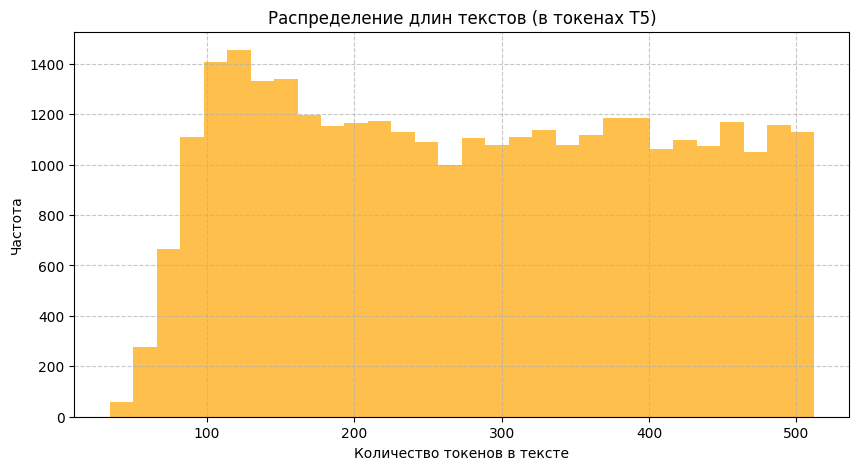

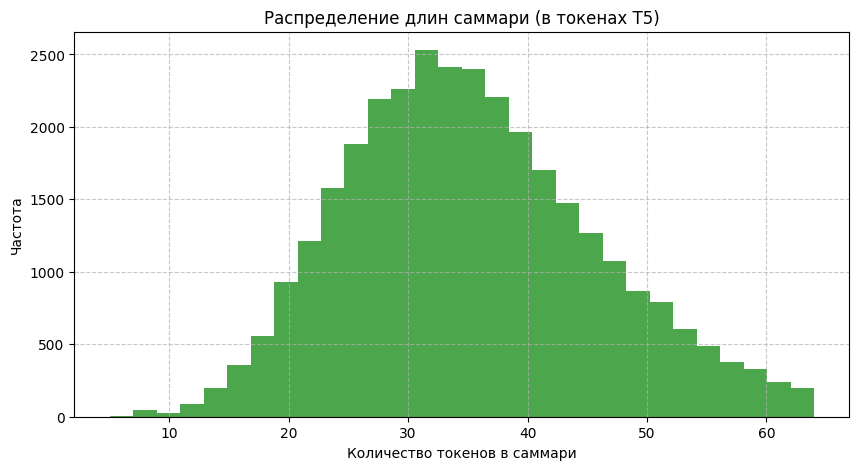

In [41]:
plt.figure(figsize=(10, 5)) 
plt.hist(data_filtered['text_len_t5_tokens'], bins=30, color='orange', alpha=0.7)
plt.title('Распределение длин текстов (в токенах T5)')
plt.xlabel('Количество токенов в тексте')
plt.ylabel('Частота')
plt.grid(True, linestyle='--', alpha=0.7) 
plt.show()


plt.figure(figsize=(10, 5)) 
plt.hist(data_filtered['summary_len_t5_tokens'], bins=30, color='green', alpha=0.7)
plt.title('Распределение длин саммари (в токенах T5)')
plt.xlabel('Количество токенов в саммари')
plt.ylabel('Частота')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Разделение на обучающую, тестовую и валидационную выборки

In [42]:
train_data, temp_data = train_test_split(
    data_filtered[['text', 'summary']],
    test_size=0.2,     
    random_state=42,   
    shuffle=True       
)

val_data, test_data = train_test_split(
    temp_data,
    test_size=0.5,      
    random_state=42,    
    shuffle=True
)

print(f"Размер обучающей выборки (train_df): {train_data.shape[0]}")
print(f"Размер валидационной выборки (val_df): {val_data.shape[0]}")
print(f"Размер тестовой выборки (test_df): {test_data.shape[0]}")


Размер обучающей выборки (train_df): 25819
Размер валидационной выборки (val_df): 3227
Размер тестовой выборки (test_df): 3228


В результате был сформирован итоговый набор данных, содержащий 32 274 уникальных пар "текст-резюме". 

Данные были разделены на обучающую (80%), валидационную (10%) и тестовую (10%) выборки.


In [43]:
output_dir = "final_data"
os.makedirs(output_dir, exist_ok=True) 

train_data[['text', 'summary']].to_csv(os.path.join(output_dir, 'train.csv'), index=False)
val_data[['text', 'summary']].to_csv(os.path.join(output_dir, 'validation.csv'), index=False)
test_data[['text', 'summary']].to_csv(os.path.join(output_dir, 'test.csv'), index=False)